In [3]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import sklearn
import math, random
import torch
import torchaudio
from torchaudio import transforms
import pandas as pd
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data import random_split
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import init
import os
import cmath
import scipy
from torch.autograd import Variable
import tqdm
import wandb
import pyroomacoustics as pyrm
from timeit import default_timer as timer

In [49]:
class InputFeature():
    
    @staticmethod
    def load_audio(audio_file):
        """
        audio_file: path to the wav file
        """
        signal, sr = torchaudio.load(audio_file)
        return signal,sr
    
    
    @staticmethod
    def getLPS_firstchannel(loaded_audio,i,sr=None):
        """
        loaded_audio: raw audio input
        sr: sampling rate
        return: log power spectrum of the first channel which is our reference mic
        """
        power_spec = torch.stft(loaded_audio[i,:],n_fft=512,return_complex=True)+1e-8
        lps = torch.abs(power_spec)**2
        s = torchaudio.transforms.AmplitudeToDB()(lps)
        return s,sr
    
    @staticmethod
    def getFullLPS(loaded_audio):
        """Gets the full lps of the audio not just the first channel as described in the paper"""
        power_spec = torch.stft(loaded_audio,n_fft=512,return_complex=True)+1e-8
#         lps = torch.abs(power_spec)**2
#         s = torchaudio.transforms.AmplitudeToDB()(lps)
        return power_spec
    @staticmethod
    def getSpatialFeature_uni(audio):
        """Old unilateral ipds"""
        
        all_ipds = np.ones(InputFeature.getLogPowerSpectrum(audio)[0].shape)
        print(all_ipds.shape)
        ###do combinations (1,3)(1,5)(3,5)
#         all_ipds.append(np.ones(InputFeature.getLogPowerSpectrum(audio)[0].shape)) #since first mic is our ref mic

        ipd_13 = InputFeature.calcIPD(audio,0,2)
        ipd_15 = InputFeature.calcIPD(audio,0,4)
        ipd_35 = InputFeature.calcIPD(audio,2,4)

        return np.concatenate([ipd_13,ipd_15,ipd_35])
    @staticmethod
    def getSpatialFeature(audio):
            #ipd for all 6 microphones
        ipd_13 = InputFeature.calcIPD(audio,0,2)
        ipd_15 = InputFeature.calcIPD(audio,0,4)
        ipd_35 = InputFeature.calcIPD(audio,2,4)
        ipd_24 = InputFeature.calcIPD(audio,1,3)
        ipd_26 = InputFeature.calcIPD(audio,1,5)
        ipd_46 = InputFeature.calcIPD(audio,3,5)
        
        ##Bilateral
        ipd_12 = InputFeature.calcIPD(audio,0,1)
        ipd_34 = InputFeature.calcIPD(audio,2,3)
        ipd_56 = InputFeature.calcIPD(audio,4,5)
        ipd_14 = InputFeature.calcIPD(audio,0,3)
        ipd_16 = InputFeature.calcIPD(audio,0,5)
        ipd_36 = InputFeature.calcIPD(audio,2,5)
        
        unilateral = [ipd_13,ipd_15,ipd_35,ipd_24,ipd_26,ipd_46]
        bilateral = [ipd_12,ipd_34,ipd_56,ipd_14,ipd_16,ipd_36]
        return  unilateral,bilateral
        
    
    @staticmethod
    def getLogPowerSpectrum(audio):
        """
        audio: loaded audio in its raw wave form
        channel_num: the microphone channel for which we want to get the mic
        retuns the audio in t-f domain by taking the stft
        """
        power_spec = torch.stft(audio,n_fft=512,return_complex=True)+1e-8 #,win_length=32,hop_length=16

        return power_spec
    
    @staticmethod
    def getMeanNorm(np_arr):
        norm = (np_arr - np.mean(np_arr))/ (np.max(np_arr) - np.min(np_arr) )
        return norm
    
    
    @staticmethod
    def calcIPD(audio,i1,i2):
        """Calculates the ipd between pairs of microphones, helper function used in getSpatialFeature method"""
        #calc ipd
        individual_ipd = np.angle(InputFeature.getLogPowerSpectrum(audio)[i1]/InputFeature.getLogPowerSpectrum(audio)[i2])
        ipd_norm = InputFeature.getMeanNorm(individual_ipd)+1e-8
        ipd_norm=np.rad2deg(ipd_norm)
        
#         #mask
        spectral_feature = InputFeature.getFullLPS(audio).real
        sp_ = spectral_feature[i1,:]
        ipd_norm[sp_ < 2] = 0 #play around with masking threshold
        
        return ipd_norm
    
        
        
    @staticmethod
    def getSv(angle,fs):
        """
        Calculates the steering vector
        angle: target azimuth angle
        """
        frequency_bin  = np.arange(0, 1 + 512 / 2) * fs / 512
        all_sv = []
        phi = [0.005,0.005,0.01] 
        c = 343 #m/s speed of sound
        w = 2 *math.pi* frequency_bin #angular freq
        all_sv.append(np.ones(len(frequency_bin))) #since refeerence mic is mic 1

        for i in range(1,len(phi)):
            t = phi[i]/c
            sv = np.exp(-1j*i*w*t*np.cos(np.deg2rad(angle))).real
            all_sv.append(sv)
        return np.array(all_sv)
    
    @staticmethod
    def getAngleFeature(ipds, sv):
        """
            For just 3 channels
            ipds: list of ipds from getIPD_withoutt_angle
            steeringvecs: list of steering vecs from getSV for all the speaker/noise
            num_channels: with CI we use 6 microphone channel or 2
            num_speaker: how many speaker source are in the audio mix
            Note: the first steering vector belongs to the target speaker
            return: Angle feature of target speaker (for 3 mics)

        """
        print(f"ipd shape is {ipds.shape} and svs shape is {len(sv)}")
        ipd = ipds.reshape(3,257,ipds.shape[1]) #i reshape to 9,257 because we have 9 microphone pairings from the 6 CI microphones
        target_AF = 0

        afs = []
        for i in range(ipd.shape[0]):
            af = ((sv[i] * ipd[i,:].T)) /(np.abs(sv[i] * ipd[i,:].T))
            af = np.nan_to_num(af)
            afs.append(af.T)
            target_AF+=af
            
            #we need to try the angle feature with just the (3,5) or just (1,3)

        return target_AF.T,afs

    @staticmethod
    def delaySumBeamformer(fs,M):
        """
        WORKING
        target_angle: azimuth of the target speaker
        M: number of microphones
        fs: sampling rate of the brir/rir/hrtf
        returns: delay-sum beamformer filter for all the angle we consider and the target beamformer is at the lat position in the list
        
        """
        # we can define the angles we want to design a beamformer filter for, in the paper the did 36 filter so i guess 36 angles 
        #and the last angle p was the angle of the target speaker.
        
        direction_grid = list(range(0,360,10))
        all_filters = []
        for angle in direction_grid:
            sv = InputFeature.getSv(angle,fs)
            f = sv/M
            all_filters.append(f)
        return all_filters
    
    @staticmethod
    def delaySumBeamformer_Directivity(fs,M,target_angle):
        """
        WORKING
        target_angle: azimuth of the target speaker
        M: number of microphones
        fs: sampling rate of the brir/rir/hrtf
        returns: delay-sum beamformer filter for all the angle we consider and the target beamformer is at the lat position in the list
        """
        # we can define the angles we want to design a beamformer filter for, in the paper the did 36 filter so i guess 36 angles 
        #and the last angle p was the angle of the target speaker.
        
        direction_grid = list(range(0,360,10))
        all_filters = []
        beam_directivity =[]
        target_beam = InputFeature.getSv(target_angle,fs)/M
        freq = []
        per_ang = []

        directivy_p =np.empty(shape=[len(direction_grid),target_beam.shape[1]])
        for j,angle in enumerate(direction_grid):
            sv = InputFeature.getSv(angle,fs)
            f=sv/M
            for i in range(target_beam.shape[1]):
                directivity = target_beam.conj().T[i,:] @ f[:,i]
                freq.append(directivity)
                directivy_p[j,i] =directivity
        return directivy_p  
    
    @staticmethod
    def help_dpr(w_h,mixed_input):
        """helper function to multiply the beamformer weights with the mixed audio"""
        all_= []
        w_h = w_h**2
        mixed_input = mixed_input**2
        for i in range(w_h.shape[0]):
            t = (w_h[i]) * (mixed_input[i,:].numpy().T)
            all_.append(np.abs(t.T)) #so we have shape freq,time
        return np.concatenate(all_)#all_

    @staticmethod
    def help_dpr_test(w_h,mixed_input):
        all_= []
        w_h = w_h**2
        mixed_input = mixed_input**2
        for i in range(mixed_input.shape[0]):
            t = (w_h) * (mixed_input[i,:].numpy().T)
            all_.append(np.abs(t.T))
        return np.concatenate(all_)
    

    
    @staticmethod
    def DPR(beamformer,audio,target_azimuth):
        """
        beamformer: the filters gotten from delaySumBeamformer
        audio: aduio mixture that is passed to the model in raw
        """
        #get audio in t-f domain
        all_ =[]

        mixed_input = InputFeature.getLogPowerSpectrum(audio)
        
        #what direction is target azimuth is to determine which channels to focus on because of the big head in between
        pos_ipd = [1,3,5]
        mixed_input = mixed_input[pos_ipd] #this takes the 3 channesls on one ear
        
        direction_grid = list(range(0,360,10))
        bin_index = np.digitize(target_azimuth,direction_grid,right=True) #select the direction grid the target azimuth falls into
        
        #get the numerator
        w_h_target = np.array(beamformer[bin_index]).conj() #get the conjugal transformed filter for the target azimuths
        
        top = InputFeature.help_dpr(w_h_target,mixed_input)

        #get the denominator
        bottom =0 
        top[top<2]=0 #mask top
        for i in range(len(beamformer)):
            w_h = np.array(beamformer[i]).conj()
            f = InputFeature.help_dpr(w_h,mixed_input)
            bottom +=f
        dpr = top /bottom
        
        return dpr, (top.real,bottom.real)

            
    @staticmethod
    def DSNR(beamformer,audio,target_azimuth,interf_azimuth):
        """
            beamformer: calculated delay beam former(delay-sum beamformer)
            audio:mixed audio
            target_azimuth: azimuth of target speaker
            interf_azimuth: azimuth of interference
            directiity: 0 or 1 to deltermine if we want the denominator as the beam weight or directivity pattern
        """
        all_ =[]

        mixed_input = InputFeature.getLogPowerSpectrum(audio)

        
        pos_ipd = [1,3,5]
        mixed_input = mixed_input[pos_ipd] #this takes the 3 channesls on one ear

        direction_grid = list(range(0,360,10))
        bin_index = np.digitize(target_azimuth,direction_grid,right=True) #select the direction grid the target azimuth falls into

        #get the numerator
        w_h_target = np.array(beamformer[bin_index]).conj() #get the conjugal transformed filter for the target azimuths
        top = InputFeature.help_dpr(w_h_target,mixed_input)
        top[top<2]=0
        #get the strongest interference(interfecnce_azimuth)

        bin_index_i = np.digitize(interf_azimuth,direction_grid,right=True)
        w_h = np.array(beamformer[bin_index_i]).conj()
        bottom = InputFeature.help_dpr(w_h,mixed_input)
        dsnr = top/bottom

        return dsnr.real, (top.real,bottom.real)
   

  
   
    

# TEST CODE FOR ALL THE METHODS

In [50]:

audio,sr = InputFeature.load_audio("/Users/u618151/Desktop/Work/Datasets/Speech/Libre-speech/Test_cliping/mixed_3.wav")
audio_t,sr = InputFeature.load_audio("/Users/u618151/Desktop/Work/Datasets/Speech/Libre-speech/Test_cliping/target_3.wav")

az=[300,75]

spectral,sr = InputFeature.getLPS_firstchannel(audio,0)
s =  InputFeature.getFullLPS(audio)
spatial_uni= InputFeature.getSpatialFeature_uni(audio)

sr=22050
sv = InputFeature.getSv(300,sr)

AF,afs = InputFeature.getAngleFeature(np.array(spatial_uni), sv) 

# # sr = 22050

beam = InputFeature.delaySumBeamformer(sr,M=3)
dpr,tb = InputFeature.DPR(beam,audio,300)
dsnr = InputFeature.DSNR(beam,audio,300,75)



(257, 869)
ipd shape is (771, 869) and svs shape is 3


/var/folders/94/61gmcl297ks56qh14zsp__7s4hr5yj/T/ipykernel_83606/2174487720.py:139: RuntimeWarning: invalid value encountered in true_divide
  af = ((sv[i] * ipd[i,:].T)) /(np.abs(sv[i] * ipd[i,:].T))


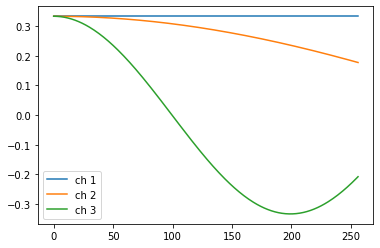

In [43]:
beam =np.array(beam)       

direction_grid = list(range(0,360,10))
bin_index = np.digitize(300,direction_grid,right=True) #select the direction grid the target azimuth falls into

#get the numerator
w_h_target = np.array(beam[0]).conj()

##line plot 

freq = list(range(0,257))
plt.plot(freq,w_h_target[0,:].real, label="ch 1")
plt.plot(freq,w_h_target[1,:].real,label="ch 2")
plt.plot(freq,w_h_target[2,:].real,label="ch 3")

plt.legend()


# PLOTS

In [51]:
def mask(audio,to_be_masked, threshold,indx):

    pos_ipd = [1,3,5]
#     to_be_masked=np.rad2deg(to_be_masked)
    spectral_feature = InputFeature.getFullLPS(audio)
    spectral_feature = spectral_feature[pos_ipd] #this only takes 1,3,5
    spectral_feature = spectral_feature[indx,:].real #spectral_feature.reshape(spectral_feature.shape[0]*spectral_feature.shape[1],spectral_feature.shape[2])       

    to_be_masked[spectral_feature < threshold] = 0

    return to_be_masked

def mask_dpr(audio,to_be_masked, threshold):
        
    pos_ipd = [1,3,5]
#     to_be_masked=np.rad2deg(to_be_masked)
    spectral_feature = InputFeature.getFullLPS(audio)
    spectral_feature = spectral_feature[pos_ipd] #this only takes 1,3,5
    spectral_feature = spectral_feature.reshape(spectral_feature.shape[0]*spectral_feature.shape[1],spectral_feature.shape[2])       

    to_be_masked[spectral_feature < threshold] = 0
        
    return to_be_masked
                            
def getPlots_AFs(target_path,interf_path,mixed_path,snr,az_list):
    
    audio_t, fs = InputFeature.load_audio(target_path)
    audio_i, fs = InputFeature.load_audio(interf_path)
    audio_m, fs = InputFeature.load_audio(mixed_path)
    sr = 22050
    
    #spatial: IPD
    ipd_target = InputFeature.getSpatialFeature_uni(audio_t)
    ipd_i = InputFeature.getSpatialFeature_uni(audio_i)
    ipd_mixed = InputFeature.getSpatialFeature_uni(audio_m)



    #spectral

    spect_m = InputFeature.getFullLPS(audio_m)
    pos_ipd = [1,3,5]
    spect_m = spect_m[pos_ipd]
    
    spect_t = InputFeature.getFullLPS(audio_t)
    spect_t = spect_t[pos_ipd]
    
    spect_i = InputFeature.getFullLPS(audio_i)
    spect_i = spect_i[pos_ipd]
    
    
    fig5, axs5 = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15,3))
    fig5.subplots_adjust(top=0.8)
    fig5.suptitle('Spectrogram',y=0.98)
    
    img_m_s_1 = librosa.display.specshow(spect_t[0,:].numpy(), y_axis='linear', x_axis = 'time',cmap=cm.jet, vmin=0,vmax=20,ax=axs5[0])
    axs5[0].set(title='target')
    axs5[0].label_outer()
    axs5[0].label_outer()
    axs5[0].set_ylim([0,8000])
    
    img_m_s_2 = librosa.display.specshow(spect_i[0,:].numpy(), y_axis='linear', x_axis = 'time',cmap=cm.jet,vmin=0,vmax=20,ax=axs5[1])
    axs5[1].set(title='Noise')
    axs5[1].label_outer()
    axs5[1].label_outer()
    axs5[1].set_ylim([0,8000])    
    
    img_m_s_3 = librosa.display.specshow(spect_m[0,:].numpy(), y_axis='linear', x_axis = 'time',cmap=cm.jet,vmin=0,vmax=20,ax=axs5[2])
    axs5[2].set(title='Mixed')
    axs5[2].label_outer()
    axs5[2].label_outer()
    axs5[2].set_ylim([0,8000])  
    
    fig5.colorbar(img_m_s_3, ax=axs5)   
    
       #IPDS

#     ipd_13 = mask(audio_m,ipd_mixed[:257], 2,0)
#     ipd_15 = mask(audio_m,ipd_mixed[257:514], 2,1)
#     ipd_35 = mask(audio_m,ipd_mixed[514:], 2,2)
    
 
    
    ipd_13 = ipd_mixed[:257]
    ipd_15 = ipd_mixed[257:514]
    ipd_35 = ipd_mixed[514:]
        
    
    
    fig5, axs5 = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15,3))
    fig5.subplots_adjust(top=0.8)
    fig5.suptitle('IPDs',y=0.98)
    
    img_m_i_1 = librosa.display.specshow(ipd_13, y_axis='linear', x_axis = 'time',cmap=cm.jet,vmin=0, vmax =20, ax=axs5[0])
    axs5[0].set(title='IPD @ ch (1,3)')
    axs5[0].label_outer()
    axs5[0].label_outer()
    axs5[0].set_ylim([0,8000])
    
    img_m_i_2 = librosa.display.specshow(ipd_15, y_axis='linear', x_axis = 'time',vmin=0, vmax =8,cmap=cm.jet,ax=axs5[1])
    axs5[1].set(title='IPD @ ch (1,5)')
    axs5[1].label_outer()
    axs5[1].label_outer()
    axs5[1].set_ylim([0,8000])    
    
    img_m_i_3 = librosa.display.specshow(ipd_35, y_axis='linear', x_axis = 'time',vmin=0, vmax =20,cmap=cm.jet,ax=axs5[2])
    axs5[2].set(title='IPD @ ch (3,5)')
    axs5[2].label_outer()
    axs5[2].label_outer()
    axs5[2].set_ylim([0,8000])  
    
    fig5.colorbar(img_m_i_3, ax=axs5) 
    
    
    
#     #mixed af
#     sv_m = InputFeature.getSv(az_list[0],fs)
    
#     AF_m,afs_m = InputFeature.getAngleFeature(ipd_mixed, sv_m)

#     afs_m_1 = mask(audio_m,afs_m[0], 2,0)
#     afs_m_2 = mask(audio_m,afs_m[1], 2,1)
#     afs_m_3 = mask(audio_m,afs_m[2], 2,2)
#     AF_m = mask(audio_m,AF_m, 2,0)

        
#     fig5, axs5 = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(15,3))
#     fig5.subplots_adjust(top=0.8)
#     fig5.suptitle('Angle Feature mixed',y=0.98)
    
#     img_m_1 = librosa.display.specshow(afs_m_1, y_axis='linear', x_axis = 'time',cmap=cm.jet,vmin=-2, vmax =5, ax=axs5[0])
#     axs5[0].set(title='AF @ ch (1,3)')
#     axs5[0].label_outer()
#     axs5[0].label_outer()
#     axs5[0].set_ylim([0,8000])
    
#     img_m_3 = librosa.display.specshow(afs_m_2, y_axis='linear', x_axis = 'time',vmin=-2, vmax =5,cmap=cm.jet,ax=axs5[1])
#     axs5[1].set(title='AF @ ch (1,5)')
#     axs5[1].label_outer()
#     axs5[1].label_outer()
#     axs5[1].set_ylim([0,8000])    
    
#     img_m_4 = librosa.display.specshow(afs_m_3, y_axis='linear', x_axis = 'time',vmin=-2, vmax =5,cmap=cm.jet,ax=axs5[2])
#     axs5[2].set(title='AF @ ch (3,5)')
#     axs5[2].label_outer()
#     axs5[2].label_outer()
#     axs5[2].set_ylim([0,8000])
    
    
#     img_m_5 = librosa.display.specshow(AF_m, y_axis='linear', x_axis = 'time',vmin=-2, vmax =5,cmap=cm.jet,ax=axs5[3])
#     axs5[3].set(title='AF summed up')
#     axs5[3].label_outer()
#     axs5[3].label_outer()
#     axs5[3].set_ylim([0,8000])   
    
#     fig5.colorbar(img_m_5, ax=axs5) 
    
    
    #DPR With bottom as directivity
    beam = InputFeature.delaySumBeamformer(fs,M=3)
    dpr_m2,tb_m2  = InputFeature.DPR(beam,audio_m,az_list[0])
    
#     dpr_m2 = mask_dpr(audio_t,dpr_m2, 2)
    top_m2 = tb_m2[0]
    bottom_m2 = tb_m2[1]
    
#     top_m2= mask_dpr(audio_m,top_m2, 2)
#     bottom_m2 = mask_dpr(audio_m,bottom_m2, 2)
        
    fig5, axs5 = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15,3))
    fig5.subplots_adjust(top=0.8)
    fig5.suptitle('DPR Mixed without beam directivity',y=0.98)
    
    img_m_1 = librosa.display.specshow(top_m2[257:514], y_axis='linear', x_axis = 'time',cmap=cm.jet,vmin=0, vmax =8, ax=axs5[0])
    axs5[0].set(title='Top')
    axs5[0].label_outer()
    axs5[0].label_outer()
    axs5[0].set_ylim([0,8000])
    fig5.colorbar(img_m_1, ax=axs5[0]) 
    
    img_m_3 = librosa.display.specshow(bottom_m2[257:514], y_axis='linear', x_axis = 'time',cmap=cm.jet,vmin=0, vmax =8,ax=axs5[1])
    axs5[1].set(title='Bottom')
    axs5[1].label_outer()
    axs5[1].label_outer()
    axs5[1].set_ylim([0,8000]) 
    fig5.colorbar(img_m_3, ax=axs5[1]) 
    
    img_m_4 = librosa.display.specshow(dpr_m2[257:514], y_axis='linear', x_axis = 'time',vmin=0.00, vmax =0.03,cmap=cm.jet,ax=axs5[2])
    axs5[2].set(title='DPR')
    axs5[2].label_outer()
    axs5[2].label_outer()
    axs5[2].set_ylim([0,8000])
    
    fig5.colorbar(img_m_4, ax=axs5[2])
    
    
    #DSNR Withithout directivity
    
    dsnr,tb_dsnr = InputFeature.DSNR(beam,audio_m,300,75)
    
#     dpr_m = mask_dpr(audio_m,dpr_m, 2)
#     top_m = mask_dpr(audio_t,top_m, 2)
#     bottom_m = mask_dpr(audio_t,bottom_m, 2)
    top_d = tb_dsnr[0]
    bottom_d = tb_dsnr[1]
        
    fig5, axs5 = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15,3))
    fig5.subplots_adjust(top=0.8)
    fig5.suptitle('DSNR  without directivity',y=0.98)
    
    img_m_1 = librosa.display.specshow(top_d[257:514], y_axis='linear', x_axis = 'time',cmap=cm.jet, vmin=0, vmax =8,ax=axs5[0])
    axs5[0].set(title='Top')
    axs5[0].label_outer()
    axs5[0].label_outer()
    axs5[0].set_ylim([0,8000])
    fig5.colorbar(img_m_1, ax=axs5[0])
    
    img_m_3 = librosa.display.specshow(bottom_d[257:514], y_axis='linear', x_axis = 'time',vmin=0, vmax = 8,cmap=cm.jet,ax=axs5[1])
    axs5[1].set(title='Bottom')
    axs5[1].label_outer()
    axs5[1].label_outer()
    axs5[1].set_ylim([0,8000])   
    fig5.colorbar(img_m_3, ax=axs5[1]) 
    
    img_m_4 = librosa.display.specshow(dsnr[257:514], y_axis='linear', x_axis = 'time',vmin=0, vmax =0.09,cmap=cm.jet,ax=axs5[2])
    axs5[2].set(title='DSNR')
    axs5[2].label_outer()
    axs5[2].label_outer()
    axs5[2].set_ylim([0,8000])
    
    fig5.colorbar(img_m_4, ax=axs5[2])   

       
    return (dpr_m2,top_m2,bottom_m2,dsnr)
    


(257, 869)
(257, 869)
(257, 869)


/Users/u618151/Desktop/Work/Tutorials/Audio classification/audio-spices/lib/python3.9/site-packages/librosa/display.py:954: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  warnings.warn(


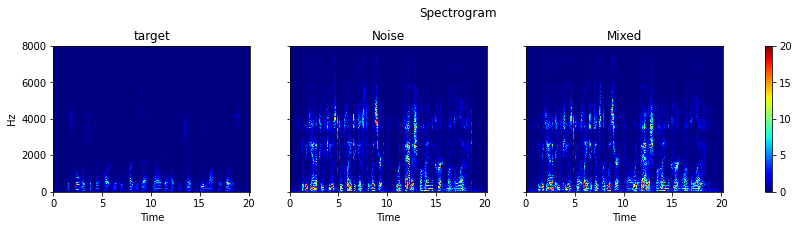

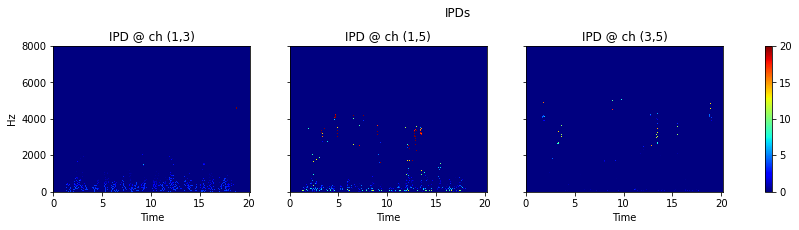

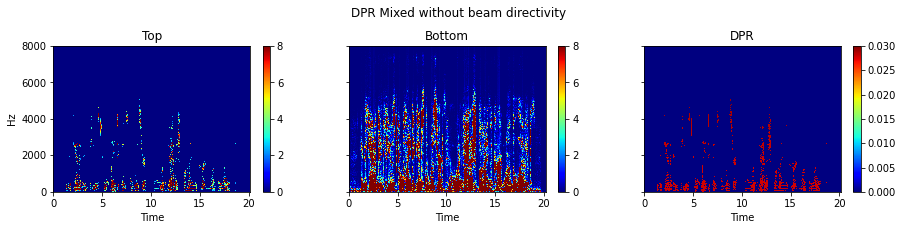

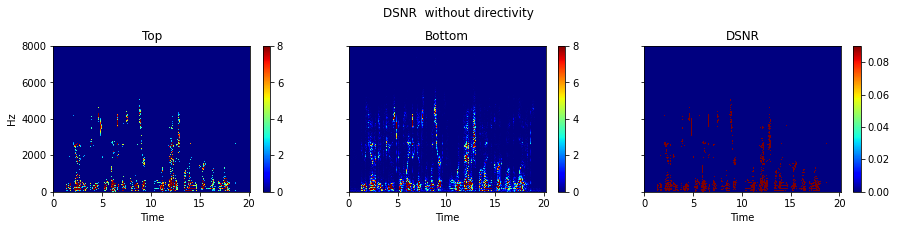

In [52]:
mixed_path = "sounds/mixed_3.wav"
target_path = "sounds/target_3.wav"
interf_path ="sounds/interf_3.wav"


snr = 5
azimuth_angles = [300,75]

dpr_m2,top_m2,bottom_m2,dsnr = getPlots_AFs(target_path,interf_path,mixed_path,snr,azimuth_angles)

# PLOT IPDS: UNI ns BILATERAL

In [53]:
def plotIPDS(uni,bi):
    #plot ipd with 3 channel and 6 channel
    fig5, axs5 = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15,3))
    fig5.subplots_adjust(top=0.8)
    fig5.suptitle('Unilateral Left Ear',y=0.98)

    img_m_1 = librosa.display.specshow(uni[0], y_axis='linear', x_axis = 'time',cmap=cm.jet,vmin=-0.5, vmax =0.5, ax=axs5[0])
    axs5[0].set(title="Back mic + Front mic")
    axs5[0].label_outer()
    axs5[0].label_outer()
    axs5[0].set_ylim([0,8000])


    img_m_3 = librosa.display.specshow(uni[1], y_axis='linear', x_axis = 'time',cmap=cm.jet,vmin=-0.5, vmax =0.5,ax=axs5[1])
    axs5[1].set(title='Back mic + T-mic')
    axs5[1].label_outer()
    axs5[1].label_outer()
    axs5[1].set_ylim([0,8000]) 

    
    img_m_4 = librosa.display.specshow(uni[2], y_axis='linear', x_axis = 'time',cmap=cm.jet,vmin=-0.5, vmax =0.5,ax=axs5[2])
    axs5[2].set(title='Front mic + T-mic')
    axs5[2].label_outer()
    axs5[2].label_outer()
    axs5[2].set_ylim([0,8000]) 
    fig5.colorbar(img_m_4, ax=axs5)
    
    fig5, axs5 = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15,3))
    fig5.subplots_adjust(top=0.8)
    fig5.suptitle('Unilateral Right Ear',y=0.98)

    img_m_1 = librosa.display.specshow(uni[3], y_axis='linear', x_axis = 'time',cmap=cm.jet,vmin=-0.5, vmax =0.5, ax=axs5[0])
    axs5[0].set(title="Back mic + Front mic")
    axs5[0].label_outer()
    axs5[0].label_outer()
    axs5[0].set_ylim([0,8000])

    img_m_3 = librosa.display.specshow(uni[4], y_axis='linear', x_axis = 'time',cmap=cm.jet,vmin=-0.5, vmax =0.5,ax=axs5[1])
    axs5[1].set(title='Back mic + T-mic')
    axs5[1].label_outer()
    axs5[1].label_outer()
    axs5[1].set_ylim([0,8000]) 
    
    img_m_4 = librosa.display.specshow(uni[5], y_axis='linear', x_axis = 'time',cmap=cm.jet,vmin=-0.5, vmax =0.5,ax=axs5[2])
    axs5[2].set(title='Front mic + T-mic')
    axs5[2].label_outer()
    axs5[2].label_outer()
    axs5[2].set_ylim([0,8000]) 
    fig5.colorbar(img_m_4, ax=axs5)   
    
    ####Bilateral
    
    fig5, axs5 = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15,3))
    fig5.subplots_adjust(top=0.8)
    fig5.suptitle('Bilateral (combining right and left ears)',y=0.98)

    img_m_1 = librosa.display.specshow(bi[0], y_axis='linear', x_axis = 'time',cmap=cm.jet,vmin=-0.5, vmax =0.5, ax=axs5[0])
    axs5[0].set(title="Back left + Back right")
    axs5[0].label_outer()
    axs5[0].label_outer()
    axs5[0].set_ylim([0,8000])

    img_m_3 = librosa.display.specshow(bi[1], y_axis='linear', x_axis = 'time',cmap=cm.jet,vmin=-0.5, vmax =0.5,ax=axs5[1])
    axs5[1].set(title="Front left + Front right")
    axs5[1].label_outer()
    axs5[1].label_outer()
    axs5[1].set_ylim([0,8000]) 
    
    img_m_4 = librosa.display.specshow(bi[2], y_axis='linear', x_axis = 'time',cmap=cm.jet,vmin=-0.5, vmax =0.5,ax=axs5[2])
    axs5[2].set(title='T-left + T-right')
    axs5[2].label_outer()
    axs5[2].label_outer()
    axs5[2].set_ylim([0,8000]) 
    fig5.colorbar(img_m_4, ax=axs5)      
    
    fig5, axs5 = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15,3))
    fig5.subplots_adjust(top=0.8)
#     fig5.suptitle('Bilateral (combining right and left ears)',y=0.98)

    img_m_1 = librosa.display.specshow(bi[3], y_axis='linear', x_axis = 'time',cmap=cm.jet,vmin=-0.5, vmax =0.5, ax=axs5[0])
    axs5[0].set(title="Back left + Front right")
    axs5[0].label_outer()
    axs5[0].label_outer()
    axs5[0].set_ylim([0,8000])

    img_m_3 = librosa.display.specshow(bi[4], y_axis='linear', x_axis = 'time',cmap=cm.jet,vmin=-0.5, vmax =0.5,ax=axs5[1])
    axs5[1].set(title="Back left + T-mic right")
    axs5[1].label_outer()
    axs5[1].label_outer()
    axs5[1].set_ylim([0,8000]) 
    
    img_m_4 = librosa.display.specshow(bi[5], y_axis='linear', x_axis = 'time',cmap=cm.jet,vmin=-0.5, vmax =0.5,ax=axs5[2])
    axs5[2].set(title='Front left + T-right')
    axs5[2].label_outer()
    axs5[2].label_outer()
    axs5[2].set_ylim([0,8000]) 
    fig5.colorbar(img_m_4, ax=axs5)                

                
                



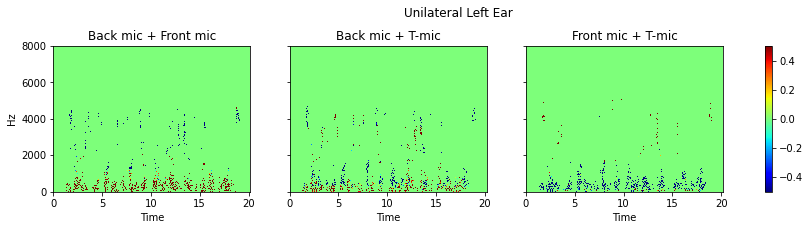

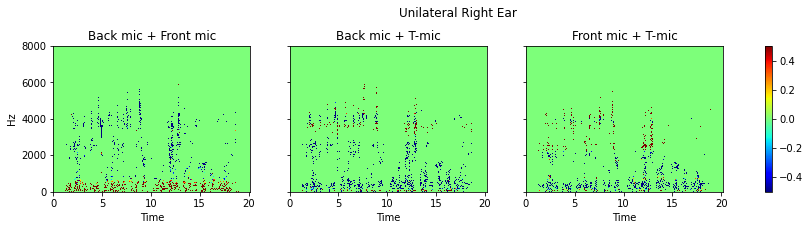

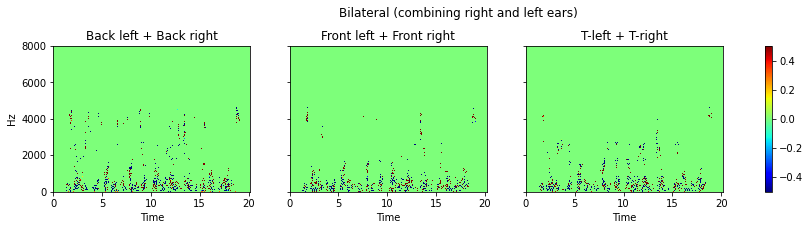

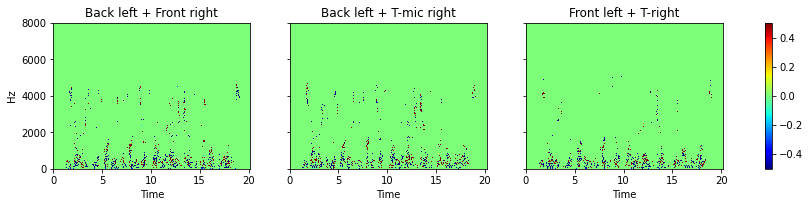

In [54]:
spatial_uni,spatial_bi= InputFeature.getSpatialFeature(audio)
plotIPDS(spatial_uni,spatial_bi)

